# End-to-end `causal-curve` demonstration: analyzing the causal impact of reducing blood lead levels in children on achievement and cognitive scores
All NHANES III data obtained here: https://wwwn.cdc.gov/nchs/nhanes/nhanes3/datafiles.aspx#core

In [1]:
from os.path import expanduser
import warnings; warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from causal_curve import GPS_Regressor
from causal_curve import Mediation


%matplotlib inline
pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [5, 4]

### Household Youth Data

In [2]:
# Location of columns in ASCII text file
cols = [
    (0,5), # Sequence number, SEQN, columns 1-5, page 
    (5,10), # Family sequence number, DMPFSEQ, columns 6-10, page
    (10,11), # Examination/interview status, DMPSTAT, columns 11, page 
    (11,12), # Race-ethnicity, DMARETHN, columns 12, page
    (12,13), # Race, DMARACER, columns 13, page
    (13,14), # Ethnicity, DMAETHNR, columns 14, page
    (14,15), # Sex, HSSEX, columns 15, page
    (20,24), # Age in months, HSAITMOR, columns 21-24, page 
    (35,41), # Poverty Income Ratio, DMPPIR, columns 36-41, page 
    (1291,1292), # persons who smoke cigarettes in home, HFF1, columns 1292, page 
    (1312,1313), # Do you have enough food to eat, sometimes not enough to eat, or often not enough to eat?, HFF4, columns 1313, page 
    (1358,1360), # Highest grade or yr of school completed, HFHEDUCR, columns 1359-1360, page 
    (1378,1379), # Did mother smoke while pregnant with SP, HYA3, columns 1379, page
    (1382,1383), # Did SP receive newborn intensive care, HYA6, columns 1383, page
]

column_names = [
    'SEQN',
    'FAMILY_SEQN',
    'STATUS',
    'RACE_ETH',
    'RACE',
    'ETH',
    'SEX',
    'AGE',
    'PIR',
    'SMOKE_HOME',
    'FOOD',
    'EDU',
    'SMOKE_PREG',
    'BABY_NICU'
]

raw_youth_file = []
with open(expanduser('~/Desktop/NHANES_III/youth.dat'), 'r') as f:
    for line in f.readlines():
        raw_youth_file.append([line[c[0]:c[1]] for c in cols])

f.close()

raw_youth_df = pd.DataFrame(raw_youth_file, columns = column_names)

### Examination Data

In [3]:
# NEED TO PARSE THIS ASCII FILE
# See: https://stackoverflow.com/questions/45286642/reading-values-from-a-text-file-using-specific-column-numbers-in-python

# Location of columns
cols = [
    (0,5), # Sequence number, SEQN, columns 1-5, page 
    (5,10), # Family sequence number, DMPFSEQ, columns 6-10, page
    (10,11), # Examination/interview status, DMPSTAT, columns 11, page 
    (4432,4434), # WISC/WRAT Math scaled score, WWPMSCSR, columns 4433-4434, page
    (4434, 4436), # WISC/WRAT Reading scaled score, WWPRSCSR, columns 4435-4436, page
    (4436, 4438), # WISC/WRAT Block design scaled score, WWPBSCSR, columns 4437-4438, page
    (4438, 4440) # WISC/WRAT Digit span scaled score, WWPDSCSR, columns 4439-4440, page
]

column_names = [
    'SEQN',
    'FAMILY_SEQN',
    'STATUS',
    'MATH',
    'READING',
    'BLOCK',
    'DIGIT'
]

raw_exam_file = []
with open(expanduser('~/Desktop/NHANES_III/exam.dat'), 'r') as f:
    for line in f.readlines():
        raw_exam_file.append([line[c[0]:c[1]] for c in cols])

f.close()

raw_exam_df = pd.DataFrame(raw_exam_file, columns = column_names)

### Laboratory Data

In [4]:
# NEED TO PARSE THIS ASCII FILE
# See: https://stackoverflow.com/questions/45286642/reading-values-from-a-text-file-using-specific-column-numbers-in-python

# Location of columns
cols = [
    (0,5), # Sequence number, SEQN, columns 1-5, page 
    (5,10), # Family sequence number, DMPFSEQ, columns 6-10, page
    (10,11), # Examination/interview status, DMPSTAT, columns 11, page 
    (1422,1426), # Lead (ug/dL), PBP, columns 1423-1426, page  
]

column_names = [
    'SEQN',
    'FAMILY_SEQN',
    'STATUS',
    'BLL'
]

raw_lab_file = []
with open(expanduser('~/Desktop/NHANES_III/lab.dat'), 'r') as f:
    for line in f.readlines():
        raw_lab_file.append([line[c[0]:c[1]] for c in cols])

f.close()

raw_lab_df = pd.DataFrame(raw_lab_file, columns = column_names)


### Merge these together

In [5]:
raw_merged_df = raw_youth_df.merge(
    raw_exam_df.drop(['FAMILY_SEQN', 'STATUS'], axis = 1), how = "left", on = "SEQN"
).merge(
    raw_lab_df.drop(['FAMILY_SEQN', 'STATUS'], axis = 1), how = "left", on = "SEQN"
)

### Column formatting and some subsetting

In [6]:
# STATUS
raw_merged_df['STATUS'] =  raw_merged_df['STATUS'].str.replace("1", "No_exam")
raw_merged_df['STATUS'] =  raw_merged_df['STATUS'].str.replace("2", "MEC_exam")
raw_merged_df['STATUS'] =  raw_merged_df['STATUS'].str.replace("3", "Home_exam")

# RACE_ETH
raw_merged_df['RACE_ETH'] =  raw_merged_df['RACE_ETH'].str.replace("1", "NH_White")
raw_merged_df['RACE_ETH'] =  raw_merged_df['RACE_ETH'].str.replace("2", "NH_Black")
raw_merged_df['RACE_ETH'] =  raw_merged_df['RACE_ETH'].str.replace("3", "Mex_Am")
raw_merged_df['RACE_ETH'] =  raw_merged_df['RACE_ETH'].str.replace("4", "Other")

# RACE
raw_merged_df['RACE'] =  raw_merged_df['RACE'].str.replace("1", "White")
raw_merged_df['RACE'] =  raw_merged_df['RACE'].str.replace("2", "Black")
raw_merged_df['RACE'] =  raw_merged_df['RACE'].str.replace("3", "Other")
raw_merged_df['RACE'] =  raw_merged_df['RACE'].str.replace("8", "Mex_Am")

# ETH
raw_merged_df['ETH'] =  raw_merged_df['ETH'].str.replace("1", "Mex_Am")
raw_merged_df['ETH'] =  raw_merged_df['ETH'].str.replace("2", "Other_Hisp")
raw_merged_df['ETH'] =  raw_merged_df['ETH'].str.replace("3", "Not_Hisp")

# SEX
raw_merged_df['SEX'] =  raw_merged_df['SEX'].str.replace("1", "Male")
raw_merged_df['SEX'] =  raw_merged_df['SEX'].str.replace("2", "Female")

# AGE
raw_merged_df['AGE'] = raw_merged_df['AGE'].astype(float) / 12

# PIR
raw_merged_df['PIR'] = raw_merged_df['PIR'].astype(float) 
raw_merged_df['PIR'][raw_merged_df['PIR'] == 888888.000] = np.nan

# EDU
raw_merged_df['EDU'] = raw_merged_df['EDU'].astype(int)
raw_merged_df['EDU'][raw_merged_df['EDU'] == 88] = None
raw_merged_df['EDU'][raw_merged_df['EDU'] == 99] = None

raw_merged_df['EDU_CAT'] = np.where(raw_merged_df['EDU'] < 9, 'LT_HS', 
    np.where(
        ((raw_merged_df['EDU'] >= 9) & (raw_merged_df['EDU'] < 12)), 'HS', 
        np.where(raw_merged_df['EDU'] == 12, 'GRAD_HS', None)
    )
)

# SMOKE_HOME
raw_merged_df['SMOKE_HOME'] = raw_merged_df['SMOKE_HOME'].str.replace("1", "Yes")
raw_merged_df['SMOKE_HOME'] = raw_merged_df['SMOKE_HOME'].str.replace("2", "No")
raw_merged_df['SMOKE_HOME'] = raw_merged_df['SMOKE_HOME'].str.replace("8", "None")

# FOOD
raw_merged_df['FOOD'] = raw_merged_df['FOOD'].str.replace("1", "Good")
raw_merged_df['FOOD'] = raw_merged_df['FOOD'].str.replace("2", "Sometimes_bad")
raw_merged_df['FOOD'] = raw_merged_df['FOOD'].str.replace("3", "Often_bad")
raw_merged_df['FOOD'] = raw_merged_df['FOOD'].str.replace("8", "None")

# SMOKE_PREG
raw_merged_df['SMOKE_PREG'] = raw_merged_df['SMOKE_PREG'].str.replace("1", "Yes")
raw_merged_df['SMOKE_PREG'] = raw_merged_df['SMOKE_PREG'].str.replace("2", "No")
raw_merged_df['SMOKE_PREG'] = raw_merged_df['SMOKE_PREG'].str.replace("8", "None")
raw_merged_df['SMOKE_PREG'] = raw_merged_df['SMOKE_PREG'].str.replace(" ", "None")

# BABY_NICU
raw_merged_df['BABY_NICU'] = raw_merged_df['BABY_NICU'].str.replace("1", "Yes")
raw_merged_df['BABY_NICU'] = raw_merged_df['BABY_NICU'].str.replace("2", "No")
raw_merged_df['BABY_NICU'] = raw_merged_df['BABY_NICU'].str.replace("8", "None")
raw_merged_df['BABY_NICU'] = raw_merged_df['BABY_NICU'].str.replace("9", "None")
raw_merged_df['BABY_NICU'] = raw_merged_df['BABY_NICU'].str.replace(" ", "None")

# Drop Nans at this point
raw_merged_df = raw_merged_df.dropna()

# MATH
raw_merged_df['MATH'] = raw_merged_df['MATH'].str.replace("NaN", "")
raw_merged_df['MATH'] = raw_merged_df['MATH'].str.replace(" ", "")
raw_merged_df['MATH'] = raw_merged_df['MATH'].str.replace("88", "")
raw_merged_df = raw_merged_df[raw_merged_df['MATH'] != '']
raw_merged_df['MATH'] = raw_merged_df['MATH'].astype(float)

# READING
raw_merged_df['READING'] = raw_merged_df['READING'].str.replace("NaN", "")
raw_merged_df['READING'] = raw_merged_df['READING'].str.replace(" ", "")
raw_merged_df['READING'] = raw_merged_df['READING'].str.replace("88", "")
raw_merged_df = raw_merged_df[raw_merged_df['READING'] != '']
raw_merged_df['READING'] = raw_merged_df['READING'].astype(float)

# BLOCK
raw_merged_df['BLOCK'] = raw_merged_df['BLOCK'].str.replace("NaN", "")
raw_merged_df['BLOCK'] = raw_merged_df['BLOCK'].str.replace(" ", "")
raw_merged_df['BLOCK'] = raw_merged_df['BLOCK'].str.replace("88", "")
raw_merged_df = raw_merged_df[raw_merged_df['BLOCK'] != '']
raw_merged_df['BLOCK'] = raw_merged_df['BLOCK'].astype(float)

# DIGIT
raw_merged_df['DIGIT'] = raw_merged_df['DIGIT'].str.replace("NaN", "")
raw_merged_df['DIGIT'] = raw_merged_df['DIGIT'].str.replace(" ", "")
raw_merged_df['DIGIT'] = raw_merged_df['DIGIT'].str.replace("88", "")
raw_merged_df = raw_merged_df[raw_merged_df['DIGIT'] != '']
raw_merged_df['DIGIT'] = raw_merged_df['DIGIT'].astype(float)

# BLL
raw_merged_df = raw_merged_df[raw_merged_df['BLL'] != '']
raw_merged_df = raw_merged_df[raw_merged_df['BLL'] != '8888']
raw_merged_df['BLL'] = raw_merged_df['BLL'].str.replace("000", "")
raw_merged_df['BLL'] = raw_merged_df['BLL'].str.replace("00", "0")
raw_merged_df['BLL'] = raw_merged_df['BLL'].str.lstrip("0")
raw_merged_df['BLL'] = raw_merged_df['BLL'].astype(float, errors = 'ignore')  
raw_merged_df['BLL'] = raw_merged_df['BLL'].str.replace(".7", "0.7")
raw_merged_df['BLL'] = raw_merged_df['BLL'].str.replace("    ", "")

raw_merged_df['BLL'] = pd.to_numeric(raw_merged_df['BLL'], errors = 'coerce')

# Once again, remove any 'None' values
raw_merged_df = raw_merged_df.dropna()

raw_merged_df = raw_merged_df[
    ((raw_merged_df['SMOKE_HOME'] != 'None') & (raw_merged_df['FOOD'] != 'None') & (raw_merged_df['SMOKE_PREG'] != 'None') & (raw_merged_df['BABY_NICU'] != 'None'))
]

format_merged_df = raw_merged_df.drop(['FAMILY_SEQN', 'STATUS', 'RACE', 'ETH', 'EDU'], axis = 1)

### Making dummy vars, prepping for causal inference

In [7]:
final_df = pd.concat(
    [
        pd.get_dummies(format_merged_df["RACE_ETH"], prefix='Race', drop_first=True),
        pd.get_dummies(format_merged_df["EDU_CAT"], prefix='Edu', drop_first=True),
        pd.get_dummies(format_merged_df["SEX"], prefix='Sex', drop_first=True),
        format_merged_df['AGE'].rename('Age'),
        format_merged_df['PIR'].rename('PIR'),
        pd.get_dummies(format_merged_df["SMOKE_HOME"], prefix='Smoke_Home', drop_first=True),
        pd.get_dummies(format_merged_df["FOOD"], prefix='Food', drop_first=True),
        pd.get_dummies(format_merged_df["SMOKE_PREG"], prefix='Smoke_Preg', drop_first=True),
        pd.get_dummies(format_merged_df["BABY_NICU"], prefix='Baby_NICU', drop_first=True),
        format_merged_df['MATH'].rename('Math'),
        format_merged_df['READING'].rename('Reading'),
        format_merged_df['BLOCK'].rename('Block'),
        format_merged_df['DIGIT'].rename('Digit'),
        format_merged_df['BLL']
    ]
    , axis = 1
)


# Let's only focus on BLLs less than 25 mg/dL. Anything above 5 mg/dL is considered elevated.
final_df = final_df[final_df['BLL'] <= 25]

# Reset index
final_df.reset_index(drop = True, inplace = True)

### Exploring the key distributions

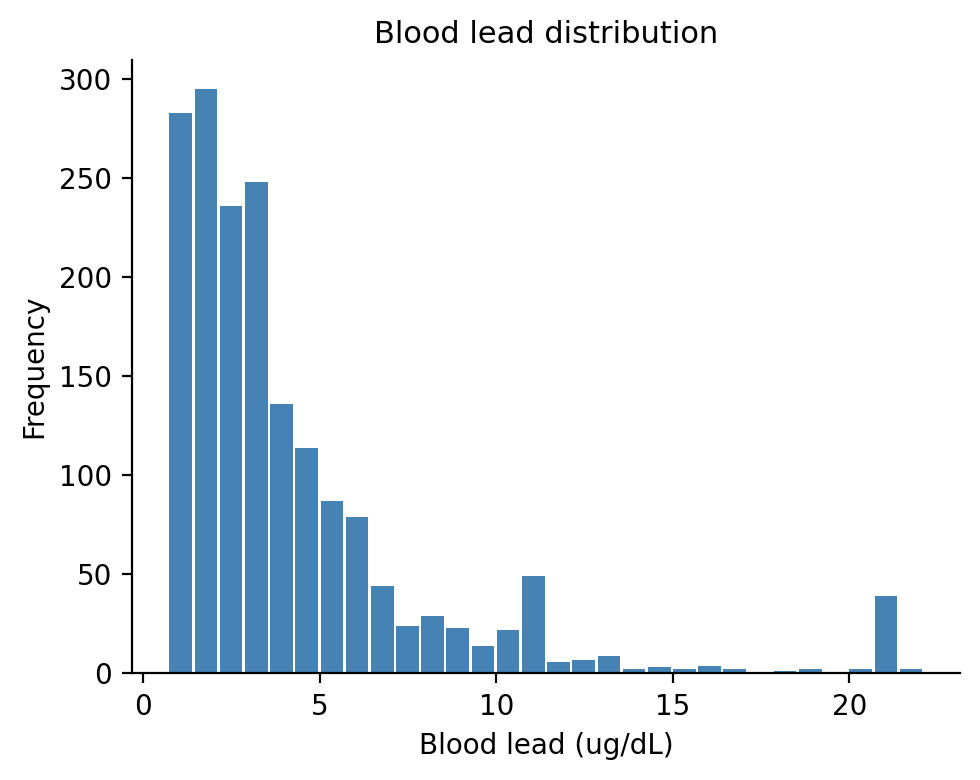

In [8]:
# Blood lead levels are log-normally distributed (an expected result...)

ax = plt.subplot(111)  
final_df['BLL'].plot.hist(bins = 30, rwidth=0.9, color = 'steelblue')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
ax.set_ylabel('Frequency')
ax.set_xlabel('Blood lead (ug/dL)')
ax.set_title("Blood lead distribution", fontsize = 11)
plt.tight_layout()
plt.savefig('BLL_dist.png', bbox_inches='tight', dpi = 300)

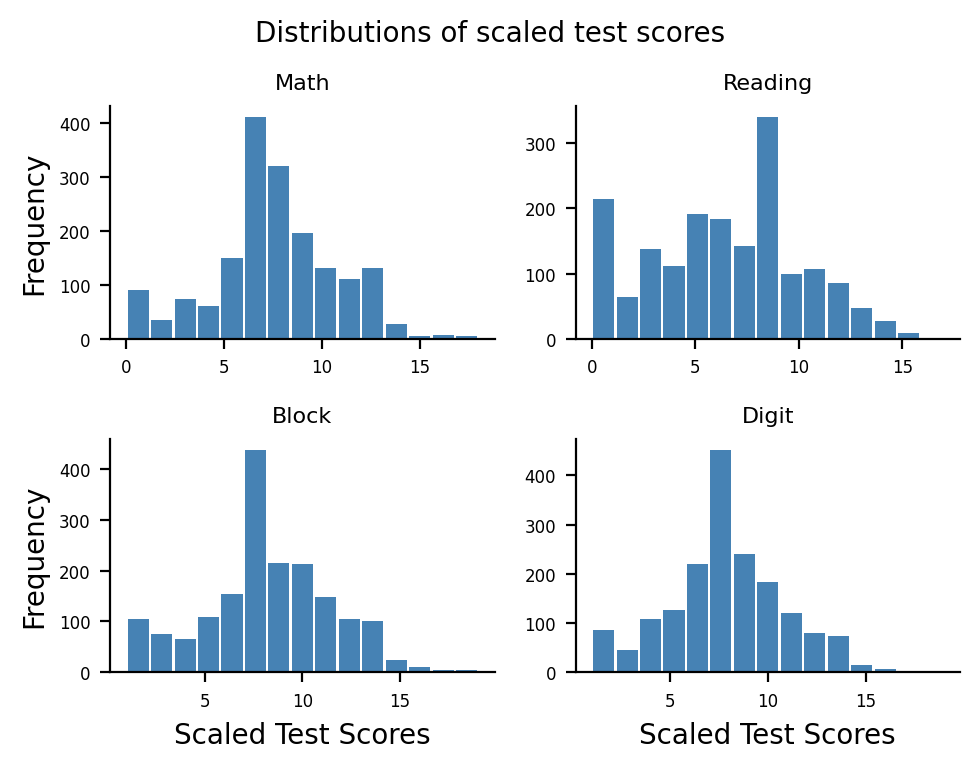

In [9]:
# See distribution of the scaled test scores

fig, axs = plt.subplots(2, 2)
final_df['Math'].plot.hist(ax=axs[0,0], bins = 15, rwidth=0.9, color = 'steelblue')
final_df['Reading'].plot.hist(ax=axs[0,1], bins = 15, rwidth=0.9, color = 'steelblue')
final_df['Block'].plot.hist(ax=axs[1,0], bins = 15, rwidth=0.9, color = 'steelblue')
final_df['Digit'].plot.hist(ax=axs[1,1], bins = 15, rwidth=0.9, color = 'steelblue')
axs[0,0].set_ylabel('Frequency')
axs[0,1].set_ylabel('')
axs[1,0].set_ylabel('Frequency')
axs[1,1].set_ylabel('')
axs[1,0].set_xlabel('Scaled Test Scores')
axs[1,1].set_xlabel('Scaled Test Scores')
axs[0,0].set_title("Math", fontsize = 8)
axs[0,1].set_title("Reading", fontsize = 8)
axs[1,0].set_title("Block", fontsize = 8)
axs[1,1].set_title("Digit", fontsize = 8)

for i in [0,1]:
    for j in [0,1]:
        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Distributions of scaled test scores", fontsize = 10)
fig.savefig('test_dist.png', bbox_inches='tight', dpi = 300)

### Perform causal inference

In [10]:
# Dictionary to store model results
results_dict = {}

# Potential confounders
potential_confounders = [
    'Age', 'Sex_Male', 'Race_NH_Black', 'Race_NH_White', 'Race_Other', 
    'Edu_HS', 'Edu_LT_HS', 'Smoke_Home_Yes', 'Baby_NICU_Yes', 'Food_Often_bad', 'Food_Sometimes_bad'
]


# Try the MATH model
math_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)
math_gps.fit(
    T=final_df['BLL'], 
    X=final_df[potential_confounders], 
    y=final_df['Math']
)

results_dict['math_CDRC'] = math_gps.calculate_CDRC()


# Try the READING model
reading_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

reading_gps.fit(
    T=final_df['BLL'], 
    X=final_df[potential_confounders],  
    y=final_df['Reading']
)

results_dict['reading_CDRC'] = reading_gps.calculate_CDRC()



# Try the Block model
block_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

block_gps.fit(
    T=final_df['BLL'], 
    X=final_df[potential_confounders],  
    y=final_df['Block']
)

results_dict['block_CDRC'] = block_gps.calculate_CDRC()



# Try the Digit model
digit_gps = GPS_Regressor(gps_family='normal', lower_grid_constraint = 0.0, upper_grid_constraint = 0.99, n_splines = 5, verbose=False)

digit_gps.fit(
    T=final_df['BLL'], 
    X=final_df[potential_confounders],  
    y=final_df['Digit']
)

results_dict['digit_CDRC'] = digit_gps.calculate_CDRC()

### Plot causal inference results

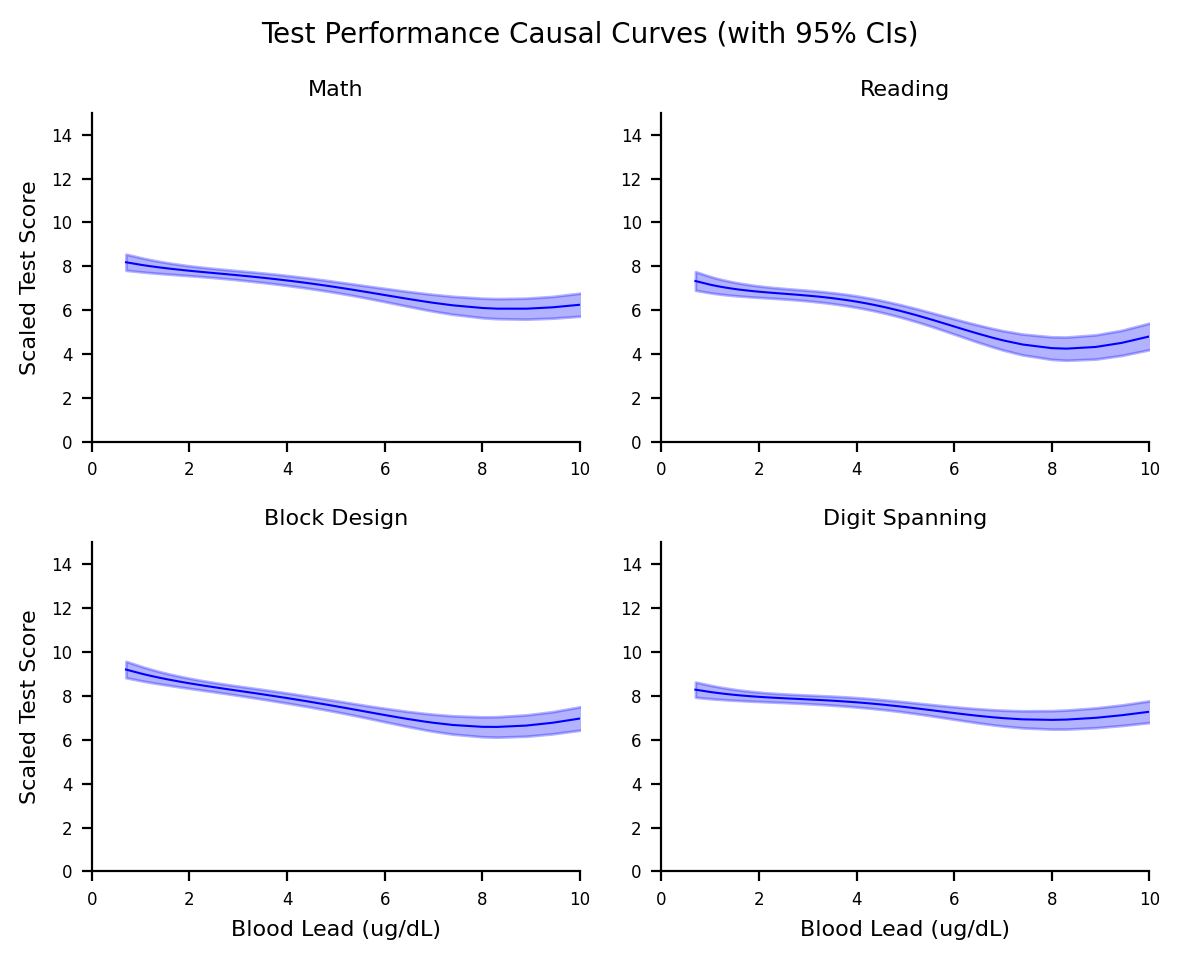

In [11]:
result_class = [['math_CDRC', 'reading_CDRC'], ['block_CDRC', 'digit_CDRC']]

result_name = [['Math', 'Reading'], ['Block Design', 'Digit Spanning']]

def plot_mean_and_CI(axs, i, j, treatment, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    axs[i,j].fill_between(treatment, lb, ub, color=color_shading, alpha=0.3)
    # plot the mean on top
    axs[i,j].plot(treatment, mean, color_mean, linewidth=0.75)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]

fig, axs = plt.subplots(2, 2)

for i in [0,1]:
    for j in [0,1]:

        # Plotting quantities
        treat = results_dict[result_class[i][j]]['Treatment']
        mean = results_dict[result_class[i][j]]['Causal_Dose_Response']
        lb = results_dict[result_class[i][j]]['Lower_CI']
        ub = results_dict[result_class[i][j]]['Upper_CI']
        plot_mean_and_CI(axs, i, j, treat, mean, lb, ub, color_mean='b', color_shading='b')

        # Labels
        axs[0,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[0,1].set_ylabel('')
        axs[1,0].set_ylabel('Scaled Test Score', fontsize = 8)
        axs[1,1].set_ylabel('')
        axs[1,0].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)
        axs[1,1].set_xlabel('Blood Lead (ug/dL)', fontsize = 8)

        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)
        axs[i,j].set_title(result_name[i][j], fontsize = 8)

        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

        axs[i,j].set_xlim(0, 10)
        axs[i,j].set_ylim(0, 15)
        
        axs[i,j].tick_params(axis='both', which='major', labelsize=6)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Test Performance Causal Curves (with 95% CIs)", fontsize = 10)
fig.savefig('test_causal_curves.png', bbox_inches='tight', dpi = 300)

### Exploring how BLLs mediate the relationship between income and cognitive outcomes

In [12]:
med = Mediation(
    bootstrap_draws=500,
    bootstrap_replicates=100,
    spline_order=3,
    n_splines=5,
    verbose=True,
)

med.fit(
    T=final_df["PIR"],
    M=final_df["BLL"],
    y=final_df["Math"],
)

med_results = med.calculate_mediation(ci = 0.95)

Using the following params for the mediation analysis:
{   'bootstrap_draws': 500,
    'bootstrap_replicates': 100,
    'lower_grid_constraint': 0.01,
    'max_iter': 100,
    'n_splines': 5,
    'random_seed': None,
    'spline_order': 3,
    'treatment_grid_num': 10,
    'upper_grid_constraint': 0.99,
    'verbose': True}
Beginning main loop through treatment bins...
***** Starting iteration 1 of 9 *****
***** Starting iteration 2 of 9 *****
***** Starting iteration 3 of 9 *****
***** Starting iteration 4 of 9 *****
***** Starting iteration 5 of 9 *****
***** Starting iteration 6 of 9 *****
***** Starting iteration 7 of 9 *****
***** Starting iteration 8 of 9 *****
***** Starting iteration 9 of 9 *****


Mean indirect effect proportion:
            0.2021 (0.1916 - 0.2576)
            


In [13]:
# Use cubic interpolation to create plot of relationship between poverty-income ratio and the proportion of mediation by BLLs
f = interp1d(med_results['Treatment_Value'], med_results['Proportion_Indirect_Effect'], kind='cubic')
PIR_grid = np.linspace(0.23, 3.10, num=100, endpoint=True)

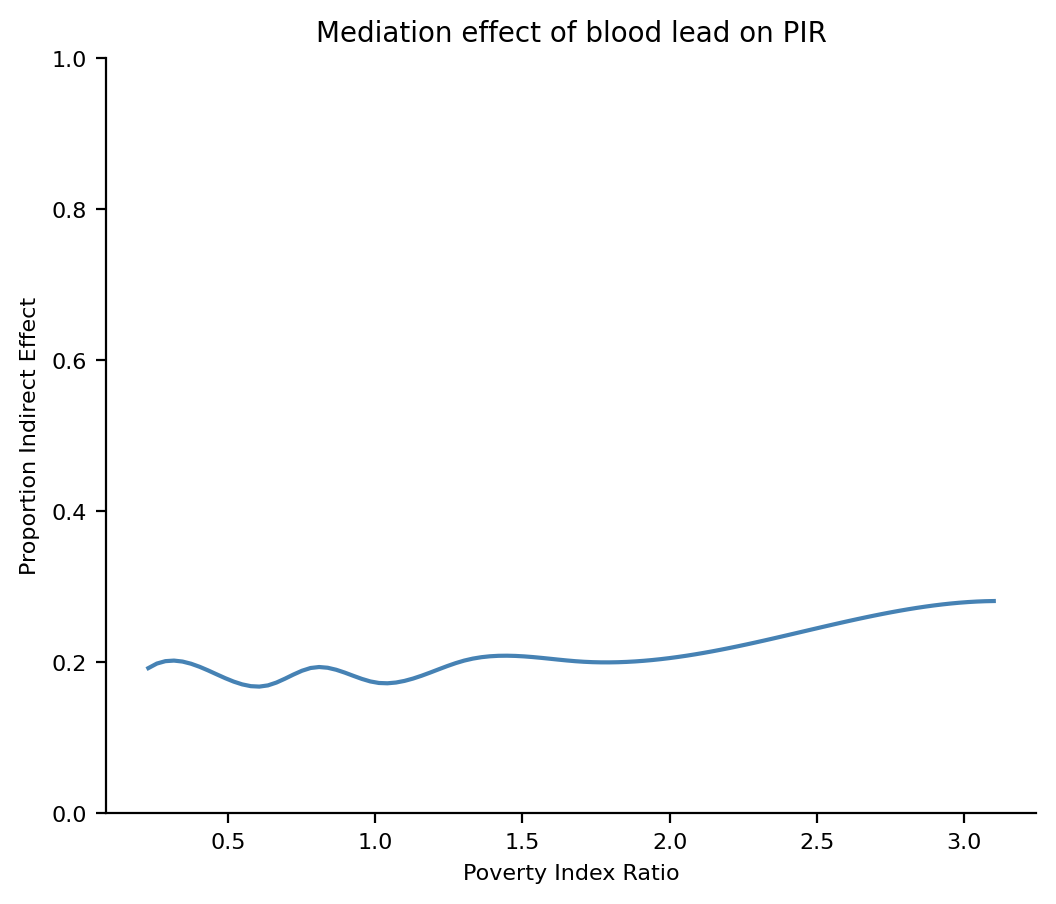

In [14]:
ax = plt.subplot(111)  
ax.plot(PIR_grid, f(PIR_grid), color = 'steelblue')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
ax.set_ylabel('Proportion Indirect Effect', fontsize = 8)
ax.set_xlabel('Poverty Index Ratio', fontsize = 8)
ax.set_ylim(0,1)
ax.set_title("Mediation effect of blood lead on PIR", fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('mediation_curve.png', bbox_inches='tight', dpi = 300)